In [48]:
import logging
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from classify_hems import check_vfr
from classify_hems import check_ifr

import classify

#sect_name = 'FH10.8'
sect_names = ['FH50.base', 'FH50_1.1', 'FH50_1.2', 'FH50_1.3', 'FH50_1.4', 'FH50_1.5', 'FH50_1.6', 'FH50_1.7', 'FH50_1.8']
#dbname = "hems-fh10.sqlite"
#sect_name = 'FH50_1.1'
dbname = "hems-fh50.sqlite"

In [49]:
sect_df = pd.read_csv('data/FH-base_sektorit.csv', sep=',')
sect_df.set_index('Sector_no', inplace=True, drop=False)
geo_df = pd.read_csv('data/Saahavaintoasemat.csv', sep=',', index_col='ICAO')
sect_df

,fid,Tukikohta,Kuvaus,distance,Sector,Sector_no,dep_dest,alt_open,sect_wx,alt_all,ASEMA,luokka,ELEV_FT,ruutu_id,min_ifr_ft,GND_max,cld_ceiling
Sector_no,,,,,,,,,,,,,,,,,
FH40.5,6,FH40,Seinäjoen tukikohta (arvio),100000,5,FH40.5,EFSI,EFTP;EFJY,ILXN,EFVA;EFKK;EFHA;EFPO;EFTP;EFJY,Kankaanpää Niinisalo lentokenttä,AWS-asema,404,22-61.5,2100,153.632996,1700
FH20.3,8,FH20,Turun lentoasema,100000,3,FH20.3,EFTU,EFTP;EFHK,ILIK,EFPO;EFTP;EFMA;EFHK;EFHA,Salo Kiikala lentokenttä,AWS-asema,384,23.5-60,2000,164.514999,1600
FH20.5,9,FH20,Turun lentoasema,100000,5,FH20.5,EFTU,EFTP;EFHK,ILZU,EFPO;EFTP;EFMA;EFHK;EFHA,Parainen Utö,AWS-asema,20,21-59.5,1400,21.108000,1400
FH20.8,10,FH20,Turun lentoasema,100000,8,FH20.8,EFTU,EFTP;EFHK,ILXF,EFPO;EFTP;EFMA;EFHK;EFHA,Rauma Kylmäpihlaja,AWS-asema,13,21-61,1700,35.522999,1700
FH20.7,11,FH20,Turun lentoasema,100000,7,FH20.7,EFTU,EFTP;EFHK,ILZI,EFPO;EFTP;EFMA;EFHK;EFHA,Kustavi Isokari,AWS-asema,16,21-60.5,1700,47.653999,1700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FH60_1.2,171,FH60,"Kelloniemi, Kuopion tukikohta",100000,2,FH60_1.2,EFKU,EFJY;EFOU;EFTP;EFHK,ILXR,EFJO;EFJY;EFSA;EFMI;EFKI;EFHA,Rautavaara Ylä-Luosta,AWS-asema,538,28.5-63,2300,292.751007,1800
FH60_1.4,172,FH60,"Kelloniemi, Kuopion tukikohta",100000,4,FH60_1.4,EFKU,EFJY;EFOU;EFTP;EFHK,ILXC,EFJO;EFJY;EFSA;EFMI;EFKI;EFHA,Varkaus Kosulanniemi,AWS-asema,272,27.5-62,2200,199.429001,1900
FH60_2.8,173,FH60_level2,"Kelloniemi, Kuopion tukikohta",150000,8,FH60_2.8,EFKU,EFJY,ILQY,EFJO;EFJY;EFSA;EFMI;EFKI;EFHA;EFLP;EFUT,Vaala Pelso,AWS-asema,371,26-64.5,1900,194.817001,1500


In [50]:
con = sqlite3.connect(dbname)

In [51]:
sect_df[['Sector_no', 'dep_dest', 'sect_wx', 'cld_ceiling', 'alt_open', 'alt_all']].to_sql('sect', con, if_exists='replace', index=False)

In [52]:
#sql = """
#SELECT metar_term.icao, metar_term.time, metar_term.temp, metar_term.vis, metar_term.rvr, metar_term.ceil, metar_term.base, metar_term.night, taf_term.taf_vis
#FROM metar metar_term
#INNER JOIN taf taf_term
#ON metar_term.icao = taf_term.icao AND metar_term.time = taf_term.time
#LEFT JOIN metar metar_sect
#"""
#df = pd.read_sql(sql, con)
#df

In [53]:
#sql = """
#SELECT sect.Sector_no AS sect_name, metar_term.time AS time, sect.dep_dest AS icao_term, #sect.sect_wx AS icao_sect,
#       metar_term.temp AS temp_term, metar_term.vis AS vis_term, metar_term.rvr AS rvr_term, metar_term.ceil AS ceil_term, metar_term.base AS base_term, metar_term.metar_msg AS metar_msg_term,
#       taf_term.taf_vis AS taf_vis_term, taf_term.taf_msg AS taf_msg_term,
#       metar_sect.temp AS temp_sect, metar_sect.vis AS vis_sect, metar_sect.rvr AS rvr_sect, metar_sect.ceil AS ceil_sect, metar_sect.base AS base_sect, metar_sect.metar_msg AS metar_msg_sect,
#       metar_term.time_of_day AS time_of_day
#FROM sect
#INNER JOIN metar metar_term
#ON icao_term = metar_term.icao
#INNER JOIN metar metar_sect
#ON icao_sect = metar_sect.icao AND metar_term.time = metar_sect.time
#LEFT JOIN taf taf_term
#ON icao_term = taf_term.icao AND metar_term.time = taf_term.time
#WHERE sect_name = :sect_name
#"""
#df = pd.read_sql(sql, con, params={'sect_name': sect_name})
df = classify.read_sector_df(con, sect_name)
df

,sect_name,time,icao_term,icao_sect,temp_term,vis_term,rvr_term,ceil_term,base_term,metar_msg_term,taf_vis_term,taf_msg_term,temp_sect,vis_sect,rvr_sect,ceil_sect,base_sect,metar_msg_sect,time_of_day
0,FH10.8,2011-01-01 06:50:00,EFHK,ILZL,-3.0,3000,2001,700,700,EFHK 010650Z 08010KT 3000 -SN BKN007 M03/M04 Q...,2500.0,EFHK 010528Z 0106/0206 09010KT 5000 -SN BKN006...,-4.0,3900.0,2001,500,500,ILZL 010650Z AUTO 10008KT 3900 SG BKN005 OVC00...,0
1,FH10.8,2011-01-02 12:50:00,EFHK,ILZL,-11.0,10000,2001,9999,9999,EFHK 021250Z 31005KT CAVOK M11/M14 Q1004 04410...,6000.0,EFHK 021136Z 0212/0312 34005KT CAVOK PROB30 TE...,-11.0,9000.0,2001,3700,3100,ILZL 021250Z AUTO 32003KT 9000 -SN SCT031 OVC0...,0
2,FH10.8,2011-01-03 03:50:00,EFHK,ILZL,-10.0,10000,2001,1700,1700,EFHK 030350Z 25002KT 9999 -SN BKN017 M10/M12 Q...,5000.0,EFHK 030234Z 0303/0403 29002KT 9999 -SN FEW010...,-10.0,4100.0,2001,1200,1200,ILZL 030350Z AUTO 29005KT 4100 -SN OVC012 M10/...,1
3,FH10.8,2011-01-08 06:50:00,EFHK,ILZL,-4.0,2000,2001,200,200,EFHK 080650Z 21007KT 2000 BR BKN002 M04/M05 Q1...,10000.0,EFHK 080529Z 0806/0906 22006KT 9999 BKN004 TEM...,-6.0,10000.0,2001,300,300,ILZL 080650Z AUTO 21004KT 9999 -SHSN BKN003 OV...,0
4,FH10.8,2011-01-08 16:50:00,EFHK,ILZL,-2.0,10000,2001,9000,700,EFHK 081650Z 12008KT 9999 FEW007 BKN090 M02/M0...,10000.0,EFHK 081427Z 0815/0915 12008KT 9999 BKN009 TEM...,-2.0,10000.0,2001,900,700,ILZL 081650Z AUTO 16009KT 9999 SCT007 BKN009 M...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153108,FH10.8,2021-12-03 08:20:00,EFHK,ILZL,-12.0,6000,2001,700,700,EFHK 030820Z 01008KT 6000 -SN BKN007 M12/M14 Q...,4000.0,EFHK 030750Z 0307/0406 01007KT 9999 -SN FEW007...,-9.0,8000.0,2001,600,600,ILZL 030820Z AUTO 03004KT 8000 -SN BKN006 M09/...,0
153109,FH10.8,2021-12-03 08:50:00,EFHK,ILZL,-12.0,7000,2001,9999,400,EFHK 030850Z 35006KT 7000 -SN FEW004 SCT007 M1...,4000.0,EFHK 030750Z 0307/0406 01007KT 9999 -SN FEW007...,-9.0,10000.0,2001,600,600,ILZL 030850Z AUTO 04007KT 9999 -SN OVC006 M09/...,0
153110,FH10.8,2021-12-03 09:20:00,EFHK,ILZL,-12.0,9000,2001,9999,400,EFHK 030920Z 36007KT 9000 -SN FEW004 M12/M13 Q...,4000.0,EFHK 030829Z 0309/0409 36007KT 9000 -SN FEW007...,-9.0,10000.0,2001,700,700,ILZL 030920Z AUTO 04007KT 9999 -SN BKN007 M09/...,0
153111,FH10.8,2021-12-03 09:50:00,EFHK,ILZL,-12.0,10000,2001,9999,400,EFHK 030950Z 36008KT 9999 -SN FEW004 SCT022 M1...,4000.0,EFHK 030829Z 0309/0409 36007KT 9000 -SN FEW007...,-9.0,10000.0,2001,700,700,ILZL 030950Z AUTO 05006KT 9999 -SN OVC007 M09/...,0


In [54]:
#sql = "SELECT alt_open, alt_all, cld_ceiling FROM sect WHERE Sector_no = :sect_name"
#df_sect = pd.read_sql(sql, con, params={'sect_name': sect_name})
#alt_open = df_sect.loc[0,'alt_open'].split(';')
#alt_all = df_sect.loc[0,'alt_all'].split(';')
#cld_ceiling = df_sect.loc[0,'cld_ceiling']

In [55]:
icao_term = sect_df.loc[sect_name, 'dep_dest']
alt_open = sect_df.loc[sect_name, 'alt_open'].split(';')
alt_all = sect_df.loc[sect_name, 'alt_all'].split(';')
cld_ceiling = sect_df.loc[sect_name, 'cld_ceiling']
#lat = geo_df.loc[icao_term, 'LAT']
#lon = geo_df.loc[icao_term, 'LON']

In [56]:
geo_df

,fid,FMISID,ASEMA,LON,LAT,ELEV_M,luokka,ELEV_FT,ruutu_id,min_ifr_ft,GND_max,cld_ceiling
ICAO,,,,,,,,,,,,
EFET,1,101976,Enontekiö lentoasema,23.427546,68.361400,308,LENTOASEMA,1010,23-68,2000,493.126007,1000
EFHA,2,101315,Jämsä Halli lentoasema,24.804592,61.855507,144,LENTOASEMA,472,24.5-61.5,2000,236.561005,1500
EFHK,3,100968,Vantaa Helsinki-Vantaan lentoasema,24.956750,60.326700,51,LENTOASEMA,167,24.5-60,2200,135.940002,2000
EFIV,4,102033,Inari Ivalo lentoasema,27.418965,68.613350,140,LENTOASEMA,459,27-68.5,3000,511.381989,2500
EFJO,5,101608,Liperi Joensuu lentoasema,29.636079,62.656950,112,LENTOASEMA,367,29.5-62.5,2900,271.160004,2500
...,...,...,...,...,...,...,...,...,...,...,...,...
ILZV,109,101028,Porvoo Harabacka,25.607297,60.391715,22,AWS-asema,72,25.5-60,1800,94.285004,1700
ILZW,110,101039,Loviisa Orrengrund,26.447587,60.274765,1,AWS-asema,3,26-60,1600,78.259003,1600
ILZX,111,874863,Espoo Tapiola,24.787433,60.177967,6,AWS-asema,20,24.5-60,2200,135.940002,2200


In [57]:
alts = alt_open

In [58]:
#sql = """
#SELECT metar.icao AS icao, metar.time as time, metar.temp AS temp, metar.rvr AS rvr, #metar.ceil AS ceil, taf.taf_vis AS taf_vis
#FROM metar
#LEFT JOIN taf
#ON metar.icao = taf.icao AND metar.time = taf.time
#"""
#sql += f"WHERE metar.icao in ({','.join(['?']*len(alts))})"
#alt_df = pd.read_sql(sql, con, params=alts, index_col=['icao', 'time']).dropna()
alt_df = classify.read_alt_df(con, alts)

In [59]:
#alt_df.loc[('EFTP', '2021-12-03 08:20:00')].iloc[0]
#alt_df[(alt_df.icao == 'EFTP') & (alt_df.time == '2021-12-03 08:20:00')].iloc[0]

In [60]:
df.dropna(inplace=True)

In [61]:
df['vfr_class'] = df.apply(check_vfr, axis=1)
#df['vfr_class'] = pd.Series(classify_vfr(lat, lon, df.time_of_day, df.vis_term, df.ceil_term, df.base_term, df.taf_vis_term, df.vis_sect, df.ceil_sect, df.base_sect) for row in df.itertuples())
df

,sect_name,time,icao_term,icao_sect,temp_term,vis_term,rvr_term,ceil_term,base_term,metar_msg_term,taf_vis_term,taf_msg_term,temp_sect,vis_sect,rvr_sect,ceil_sect,base_sect,metar_msg_sect,time_of_day,vfr_class
0,FH10.8,2011-01-01 06:50:00,EFHK,ILZL,-3.0,3000,2001,700,700,EFHK 010650Z 08010KT 3000 -SN BKN007 M03/M04 Q...,2500.0,EFHK 010528Z 0106/0206 09010KT 5000 -SN BKN006...,-4.0,3900.0,2001,500,500,ILZL 010650Z AUTO 10008KT 3900 SG BKN005 OVC00...,0,DAY HEMS VFR
1,FH10.8,2011-01-02 12:50:00,EFHK,ILZL,-11.0,10000,2001,9999,9999,EFHK 021250Z 31005KT CAVOK M11/M14 Q1004 04410...,6000.0,EFHK 021136Z 0212/0312 34005KT CAVOK PROB30 TE...,-11.0,9000.0,2001,3700,3100,ILZL 021250Z AUTO 32003KT 9000 -SN SCT031 OVC0...,0,DAY HEMS VFR
2,FH10.8,2011-01-03 03:50:00,EFHK,ILZL,-10.0,10000,2001,1700,1700,EFHK 030350Z 25002KT 9999 -SN BKN017 M10/M12 Q...,5000.0,EFHK 030234Z 0303/0403 29002KT 9999 -SN FEW010...,-10.0,4100.0,2001,1200,1200,ILZL 030350Z AUTO 29005KT 4100 -SN OVC012 M10/...,1,NIGHT HEMS VFR
3,FH10.8,2011-01-08 06:50:00,EFHK,ILZL,-4.0,2000,2001,200,200,EFHK 080650Z 21007KT 2000 BR BKN002 M04/M05 Q1...,10000.0,EFHK 080529Z 0806/0906 22006KT 9999 BKN004 TEM...,-6.0,10000.0,2001,300,300,ILZL 080650Z AUTO 21004KT 9999 -SHSN BKN003 OV...,0,DAY BELOW VFR
4,FH10.8,2011-01-08 16:50:00,EFHK,ILZL,-2.0,10000,2001,9000,700,EFHK 081650Z 12008KT 9999 FEW007 BKN090 M02/M0...,10000.0,EFHK 081427Z 0815/0915 12008KT 9999 BKN009 TEM...,-2.0,10000.0,2001,900,700,ILZL 081650Z AUTO 16009KT 9999 SCT007 BKN009 M...,1,NIGHT BELOW VFR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153108,FH10.8,2021-12-03 08:20:00,EFHK,ILZL,-12.0,6000,2001,700,700,EFHK 030820Z 01008KT 6000 -SN BKN007 M12/M14 Q...,4000.0,EFHK 030750Z 0307/0406 01007KT 9999 -SN FEW007...,-9.0,8000.0,2001,600,600,ILZL 030820Z AUTO 03004KT 8000 -SN BKN006 M09/...,0,DAY HEMS VFR
153109,FH10.8,2021-12-03 08:50:00,EFHK,ILZL,-12.0,7000,2001,9999,400,EFHK 030850Z 35006KT 7000 -SN FEW004 SCT007 M1...,4000.0,EFHK 030750Z 0307/0406 01007KT 9999 -SN FEW007...,-9.0,10000.0,2001,600,600,ILZL 030850Z AUTO 04007KT 9999 -SN OVC006 M09/...,0,DAY HEMS VFR
153110,FH10.8,2021-12-03 09:20:00,EFHK,ILZL,-12.0,9000,2001,9999,400,EFHK 030920Z 36007KT 9000 -SN FEW004 M12/M13 Q...,4000.0,EFHK 030829Z 0309/0409 36007KT 9000 -SN FEW007...,-9.0,10000.0,2001,700,700,ILZL 030920Z AUTO 04007KT 9999 -SN BKN007 M09/...,0,DAY HEMS VFR
153111,FH10.8,2021-12-03 09:50:00,EFHK,ILZL,-12.0,10000,2001,9999,400,EFHK 030950Z 36008KT 9999 -SN FEW004 SCT022 M1...,4000.0,EFHK 030829Z 0309/0409 36007KT 9000 -SN FEW007...,-9.0,10000.0,2001,700,700,ILZL 030950Z AUTO 05006KT 9999 -SN OVC007 M09/...,0,DAY HEMS VFR


In [62]:
df['ifr_class'] = df.apply(lambda row: check_ifr(row, alt_df, alts, cld_ceiling), axis=1)
df

,sect_name,time,icao_term,icao_sect,temp_term,vis_term,rvr_term,ceil_term,base_term,metar_msg_term,...,taf_msg_term,temp_sect,vis_sect,rvr_sect,ceil_sect,base_sect,metar_msg_sect,time_of_day,vfr_class,ifr_class
0,FH10.8,2011-01-01 06:50:00,EFHK,ILZL,-3.0,3000,2001,700,700,EFHK 010650Z 08010KT 3000 -SN BKN007 M03/M04 Q...,...,EFHK 010528Z 0106/0206 09010KT 5000 -SN BKN006...,-4.0,3900.0,2001,500,500,ILZL 010650Z AUTO 10008KT 3900 SG BKN005 OVC00...,0,DAY HEMS VFR,DAY IFR NO CLOUD BREAK
1,FH10.8,2011-01-02 12:50:00,EFHK,ILZL,-11.0,10000,2001,9999,9999,EFHK 021250Z 31005KT CAVOK M11/M14 Q1004 04410...,...,EFHK 021136Z 0212/0312 34005KT CAVOK PROB30 TE...,-11.0,9000.0,2001,3700,3100,ILZL 021250Z AUTO 32003KT 9000 -SN SCT031 OVC0...,0,DAY HEMS VFR,DAY IFR ICING
2,FH10.8,2011-01-03 03:50:00,EFHK,ILZL,-10.0,10000,2001,1700,1700,EFHK 030350Z 25002KT 9999 -SN BKN017 M10/M12 Q...,...,EFHK 030234Z 0303/0403 29002KT 9999 -SN FEW010...,-10.0,4100.0,2001,1200,1200,ILZL 030350Z AUTO 29005KT 4100 -SN OVC012 M10/...,1,NIGHT HEMS VFR,NIGHT IFR NO CLOUD BREAK
3,FH10.8,2011-01-08 06:50:00,EFHK,ILZL,-4.0,2000,2001,200,200,EFHK 080650Z 21007KT 2000 BR BKN002 M04/M05 Q1...,...,EFHK 080529Z 0806/0906 22006KT 9999 BKN004 TEM...,-6.0,10000.0,2001,300,300,ILZL 080650Z AUTO 21004KT 9999 -SHSN BKN003 OV...,0,DAY BELOW VFR,DAY IFR NO CLOUD BREAK
4,FH10.8,2011-01-08 16:50:00,EFHK,ILZL,-2.0,10000,2001,9000,700,EFHK 081650Z 12008KT 9999 FEW007 BKN090 M02/M0...,...,EFHK 081427Z 0815/0915 12008KT 9999 BKN009 TEM...,-2.0,10000.0,2001,900,700,ILZL 081650Z AUTO 16009KT 9999 SCT007 BKN009 M...,1,NIGHT BELOW VFR,NIGHT IFR NO CLOUD BREAK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153108,FH10.8,2021-12-03 08:20:00,EFHK,ILZL,-12.0,6000,2001,700,700,EFHK 030820Z 01008KT 6000 -SN BKN007 M12/M14 Q...,...,EFHK 030750Z 0307/0406 01007KT 9999 -SN FEW007...,-9.0,8000.0,2001,600,600,ILZL 030820Z AUTO 03004KT 8000 -SN BKN006 M09/...,0,DAY HEMS VFR,DAY IFR NO CLOUD BREAK
153109,FH10.8,2021-12-03 08:50:00,EFHK,ILZL,-12.0,7000,2001,9999,400,EFHK 030850Z 35006KT 7000 -SN FEW004 SCT007 M1...,...,EFHK 030750Z 0307/0406 01007KT 9999 -SN FEW007...,-9.0,10000.0,2001,600,600,ILZL 030850Z AUTO 04007KT 9999 -SN OVC006 M09/...,0,DAY HEMS VFR,DAY IFR NO CLOUD BREAK
153110,FH10.8,2021-12-03 09:20:00,EFHK,ILZL,-12.0,9000,2001,9999,400,EFHK 030920Z 36007KT 9000 -SN FEW004 M12/M13 Q...,...,EFHK 030829Z 0309/0409 36007KT 9000 -SN FEW007...,-9.0,10000.0,2001,700,700,ILZL 030920Z AUTO 04007KT 9999 -SN BKN007 M09/...,0,DAY HEMS VFR,DAY IFR NO CLOUD BREAK
153111,FH10.8,2021-12-03 09:50:00,EFHK,ILZL,-12.0,10000,2001,9999,400,EFHK 030950Z 36008KT 9999 -SN FEW004 SCT022 M1...,...,EFHK 030829Z 0309/0409 36007KT 9000 -SN FEW007...,-9.0,10000.0,2001,700,700,ILZL 030950Z AUTO 05006KT 9999 -SN OVC007 M09/...,0,DAY HEMS VFR,DAY IFR NO CLOUD BREAK


In [63]:
#sql = """
#SELECT metar_term.icao, metar_term.time, metar_term.temp, metar_term.vis, metar_term.rvr, metar_term.ceil, metar_term.base, metar_term.night, taf_term.taf_vis
#FROM metar metar_term
#INNER JOIN taf_term
#ON metar.icao = taf.icao AND metar.time = taf.time
#LEFT JOIN metar metar_sect
#"""
#df = pd.read_sql(sql, con)
#df

In [64]:
df.ifr_class.value_counts()

DAY HEMS IFR                     46953
NIGHT IFR ICING                  28576
NIGHT IFR NO CLOUD BREAK         21524
DAY IFR ICING                    20195
DAY IFR NO CLOUD BREAK           18216
NIGHT HEMS IFR                   13813
DAY BELOW IFR                      624
NIGHT BELOW IFR                    236
DAY HEMS VFR RETURN NIGHT IFR      235
DAY IFR NO ALTERNATE               223
NIGHT IFR NO ALTERNATE             168
Name: ifr_class, dtype: int64

In [65]:
df.vfr_class.value_counts()

DAY HEMS VFR                81352
NIGHT HEMS VFR              30429
NIGHT BELOW VFR             25585
NIGHT VFR HEMS FEW CLOUD     5348
DAY BELOW VFR                5013
SUNDOWN HEMS VFR             2250
SUNDOWN BELOW VFR             786
Name: vfr_class, dtype: int64

In [66]:
allowing_classes = ['DAY HEMS VFR', 'SUNDOWN HEMS VFR', 'NIGHT HEMS VFR', 'DAY HEMS IFR', 'DAY HEMS VFR RETURN NIGHT IFR', 'NIGHT HEMS IFR']
len(df[df.vfr_class.isin(allowing_classes) | df.ifr_class.isin(allowing_classes)])

117281

In [67]:
vfr_allowing_classes = ['DAY HEMS VFR', 'SUNDOWN HEMS VFR', 'NIGHT HEMS VFR']
ifr_allowing_classes = ['DAY HEMS IFR', 'DAY HEMS VFR RETURN NIGHT IFR', 'NIGHT HEMS IFR']
icing_classes = ['DAY IFR ICING', 'NIGHT IFR ICING']

In [68]:
len(df)

150763

In [69]:
df['month'] = df.time.str.slice(5, 7).astype(int)
df['hour'] = df.time.str.slice(11, 13).astype(int)

In [70]:
pd.DataFrame(df.vfr_class.groupby([df.month, df.hour]).value_counts())[:40]

vfr_class
month hour vfr_class                          
1     0    NIGHT BELOW VFR                 295
           NIGHT HEMS VFR                  133
           NIGHT VFR HEMS FEW CLOUD         30
      1    NIGHT BELOW VFR                 298
           NIGHT HEMS VFR                  133
           NIGHT VFR HEMS FEW CLOUD         28
      2    NIGHT BELOW VFR                 294
           NIGHT HEMS VFR                  132
           NIGHT VFR HEMS FEW CLOUD         32
      3    NIGHT BELOW VFR                 291
           NIGHT HEMS VFR                  130
           NIGHT VFR HEMS FEW CLOUD         40
      4    NIGHT BELOW VFR                 297
           NIGHT HEMS VFR                  127
           NIGHT VFR HEMS FEW CLOUD         40
      5    NIGHT BELOW VFR                 290
           NIGHT HEMS VFR                  126
           NIGHT VFR HEMS FEW CLOUD         49
      6    DAY HEMS VFR                    323
           DAY BELOW VFR                    56
           NIGHT BELOW VFR                  54
           NIGHT HEMS VFR                   25
           NIGHT VFR HEMS FEW CLOUD         10
      7    DAY HEMS VFR                    393
           DAY BELOW VFR                    74
      8    DAY HEMS VFR                    393
           DAY BELOW VFR                    76
      9    DAY HEMS VFR                    406
           DAY BELOW VFR                    63
      10   DAY HEMS VFR                    415
           DAY BELOW VFR                    59
      11   DAY HEMS VFR                    419
           DAY BELOW VFR                    53
      12   DAY HEMS VFR                    414
           DAY BELOW VFR                    55
      13   DAY HEMS VFR                    283
           SUNDOWN BELOW VFR                62
           SUNDOWN HEMS VFR                 61
           DAY BELOW VFR                    54
           NIGHT BELOW VFR                   7

In [71]:
df.isnull().sum()

sect_name         0
time              0
icao_term         0
icao_sect         0
temp_term         0
vis_term          0
rvr_term          0
ceil_term         0
base_term         0
metar_msg_term    0
taf_vis_term      0
taf_msg_term      0
temp_sect         0
vis_sect          0
rvr_sect          0
ceil_sect         0
base_sect         0
metar_msg_sect    0
time_of_day       0
vfr_class         0
ifr_class         0
month             0
hour              0
dtype: int64

In [76]:
df['can_fly'] = (df.vfr_class.isin(allowing_classes) | df.ifr_class.isin(allowing_classes)).astype(int)

In [77]:
df['VFR'] = df.vfr_class.isin(vfr_allowing_classes).astype(int)
df['IFR'] = df.ifr_class.isin(ifr_allowing_classes).astype(int) & (df.VFR == 0)
df['NO FLY ICING'] = df.ifr_class.isin(icing_classes).astype(int) & (df.VFR == 0) & (df.IFR == 0)
df['NO FLY'] = (df.VFR == 0) & (df.IFR == 0) & (df['NO FLY ICING'] == 0)

In [74]:
#df.to_excel(f'naytepala-{sect_name}.xlsx')

In [78]:
canfly = pd.DataFrame(df.can_fly.groupby([df.month, df.hour]).sum() / df.can_fly.groupby([df.month, df.hour]).size())
#pd.DataFrame(df.can_fly.groupby([df.month, df.hour]).sum())[:40]
canfly['VFR'] = df.VFR.groupby([df.month, df.hour]).sum() / df.groupby([df.month, df.hour]).size()
canfly['IFR'] = df.IFR.groupby([df.month, df.hour]).sum() / df.groupby([df.month, df.hour]).size()
canfly['NO FLY ICING'] = df['NO FLY ICING'].groupby([df.month, df.hour]).sum() / df.groupby([df.month, df.hour]).size()
canfly['NO FLY'] = df['NO FLY'].groupby([df.month, df.hour]).sum() / df.groupby([df.month, df.hour]).size()
canfly = canfly.drop('can_fly', axis=1)
canfly.insert(0, 'sector', sect_name)

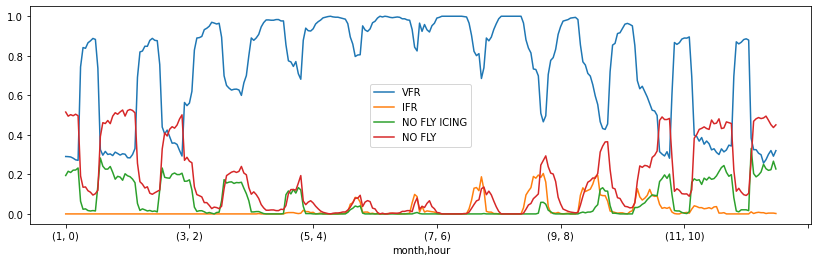

In [79]:
canfly.plot(figsize=(14,4))
plt.savefig(f'canfly-{sect_name}.png', dpi=300)

In [80]:
canfly.to_csv(f'canfly-{sect_name}.csv')